

# Project: Investigate a Dataset (No-Show Appointment)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. The dataset contains factors which may be important in predicting whether or not a patient will show up for an appointment. In this report, I will find which of the factors (age, gender, SMS remainder, diabetes, hypertension, alcoholism, handicap) can determine whether a patient shows up or not.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
# load the data
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [3]:
#display the first 5 rows
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


This shows the data types of the columns in the dataset. 

In [5]:
sum(df.duplicated())

0

The dataset contains no duplicates.

In [6]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

The dataset does not contain any null values.

In [7]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The minimum age  is -1 which shouldn't be. This indicates the presence of an outlier. Also the datatype of ScheduledDay' and 'AppointmentDay' should be datetime.


### Data Cleaning 

In [8]:
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'], format="%Y-%m-%dT%H:%M:%SZ")
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'], format="%Y-%m-%dT%H:%M:%SZ")

I changed the datatype of the 'ScheduledDay' and 'AppointmentDay' columns to datetime

In [9]:
df = df[~(df['Age'] < 0)]

Age that is less than zero is an incorrect so I filtered it out of the dataset

<a id='eda'></a>
## Exploratory Data 



### Research Question 1 (Are females more likely to show up for appointments than males?)

Let's define some functions

In [10]:
def factor_percent(factor): #calculates the percentage of patients that showed up
    Absent = df[df['No-show'] == 'Yes'].groupby(['No-show',factor])['PatientId'].count()#Number of absent patients
    Total = Total = df.groupby([factor])['PatientId'].count() #Total number of patients
    Percent = Absent/Total * 100
    return Percent

In [11]:
def plot_percentage(Percent,factor): #plots the percentage of patients that showed up based on specified factor
    Absent_No = Percent.loc['Yes',0]
    Absent_Yes = Percent.loc['Yes',1]
    plt.bar('No',Absent_No)
    plt.bar('Yes',Absent_Yes)
    plt.xlabel(factor)
    plt.ylabel('Percentage of Patients')
    plt.title('Percentage of Patients that did not show up')
    plt.show()

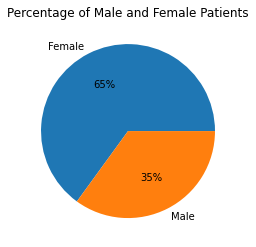

In [12]:
plt.pie(df['Gender'].value_counts(),labels = ['Female','Male'],autopct='%.0f%%')
plt.title('Percentage of Male and Female Patients')
plt.show()

About 65% of the patients are female while 35% of them are male.

In [13]:
Percent_Absent = factor_percent('Gender')

In [14]:
Absent_Female = Percent_Absent.loc['Yes','F']
Absent_Male = Percent_Absent.loc['Yes','M']

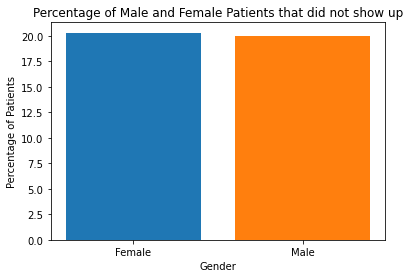

In [15]:
plt.bar('Female',Absent_Female)
plt.bar('Male',Absent_Male)
plt.xlabel('Gender')
plt.ylabel('Percentage of Patients')
plt.title('Percentage of Male and Female Patients that did not show up')
plt.show()

There is almost no difference in the percentage of male and female that show up for appointments so Gender does not determine whether a patient will show up or not

### Research Question 2  (Does sending an SMS make more patients not miss an appoinment?)

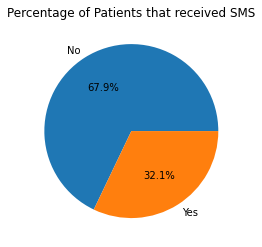

In [16]:
plt.pie(df['SMS_received'].value_counts(),labels = ['No','Yes'],autopct='%.1f%%')
plt.title('Percentage of Patients that received SMS')
plt.show()


About 32.1% of the patients received remainder SMS while 67.9% of them did.

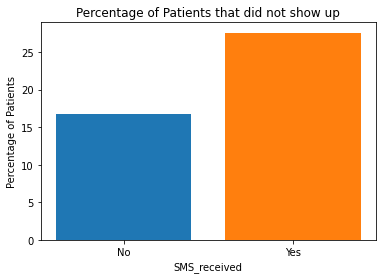

In [17]:
plot_percentage(factor_percent('SMS_received'),'SMS_received')

About 28% of the patients who received SMS still did not show up for the appointments and about 17% of those that didn't receive SMS didn't show up

### Research Question 3  (Are patients with high Handicap levels less likely to show up?)

In [18]:
df['Handcap'].value_counts(normalize=True)

0    0.979724
1    0.018475
2    0.001656
3    0.000118
4    0.000027
Name: Handcap, dtype: float64

In [19]:
Percent_Handicap = factor_percent('Handcap')

In [20]:
Handicap_0 = Percent_Handicap.loc['Yes',0]
Handicap_1 = Percent_Handicap.loc['Yes',1]
Handicap_2 = Percent_Handicap.loc['Yes',2]
Handicap_3 = Percent_Handicap.loc['Yes',3]
Handicap_4 = Percent_Handicap.loc['Yes',4]

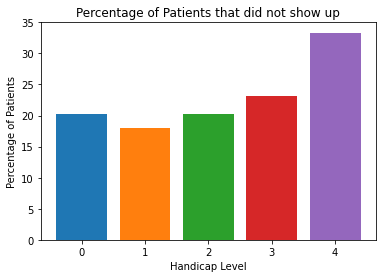

In [21]:
plt.bar('0',Handicap_0)
plt.bar('1',Handicap_1)
plt.bar('2',Handicap_2)
plt.bar('3',Handicap_3)
plt.bar('4',Handicap_4)
plt.xlabel('Handicap Level')
plt.ylabel('Percentage of Patients')
plt.title('Percentage of Patients that did not show up')
plt.show()

Patients with Handicap levels 3 and 4 did not show up the most for appointments

### Research Question 4  (Does age determine whether a patient will show up?)

<AxesSubplot:>

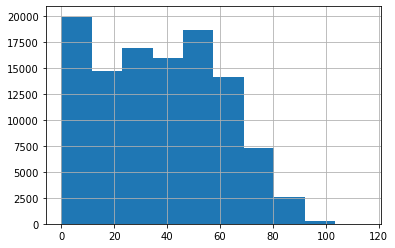

In [22]:
df['Age'].hist()

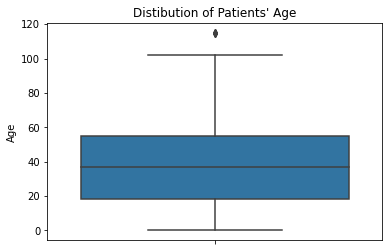

In [23]:
sns.boxplot(y='Age',data=df)
plt.title("Distibution of Patients' Age")
plt.show()

In [24]:
# Create bins to group the age into categories
df['Age Category'] = pd.cut(df['Age'],[-1,15,25,65,150],labels=['Children','Youth','Adults','Seniors'])

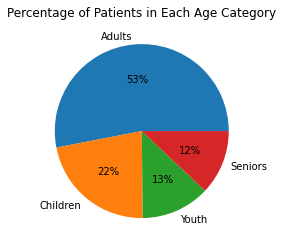

In [25]:
plt.pie(df['Age Category'].value_counts(),labels = ['Adults','Children','Youth','Seniors'],autopct='%.0f%%')
plt.title('Percentage of Patients in Each Age Category')
plt.show()

53% of the patients are Adults(25-64yrs), 22% are Children(0-14yrs), 13% are Youth(15-24yrs) and 12% are Seniors(65+ yrs)

In [26]:
Percent_Ages =factor_percent('Age Category')

In [27]:
Children = Percent_Ages.loc['Yes','Children']
Youth = Percent_Ages.loc['Yes','Youth']
Adults = Percent_Ages.loc['Yes','Adults']
Seniors = Percent_Ages.loc['Yes','Seniors']


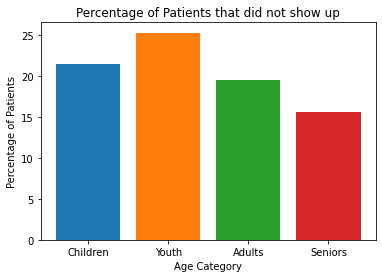

In [28]:
plt.bar('Children',Children)
plt.bar('Youth',Youth)
plt.bar('Adults',Adults)
plt.bar('Seniors',Seniors)

plt.xlabel('Age Category')
plt.ylabel('Percentage of Patients')
plt.title('Percentage of Patients that did not show up')
plt.show()

Youth and children did not show up for appointments the most

### Research Question 4 (Does having a scholarship determine whether a patient will show up?)

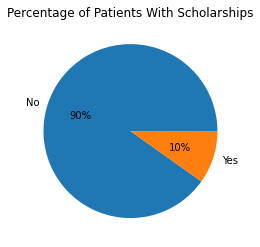

In [29]:
plt.pie(df['Scholarship'].value_counts(),labels=['No','Yes'],autopct='%.0f%%')
plt.title('Percentage of Patients With Scholarships')
plt.show()

Only about 10% of the patients have sholarship

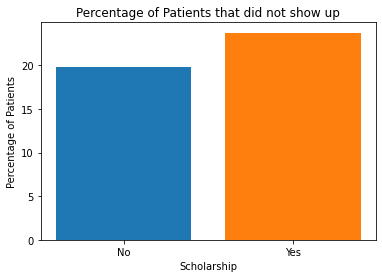

In [30]:
plot_percentage(factor_percent('Scholarship'),'Scholarship')

Scholarship doesn't really determine whether a patient shows up or not

## What other factors may determine whether a patient shows up or not?

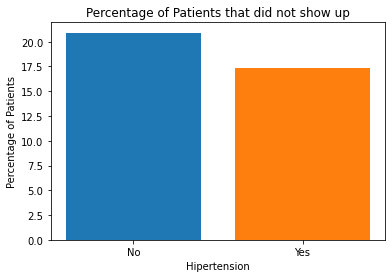

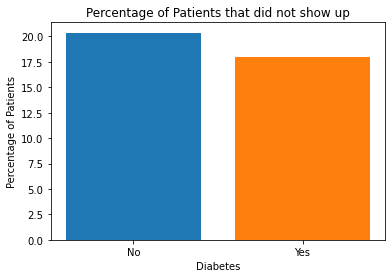

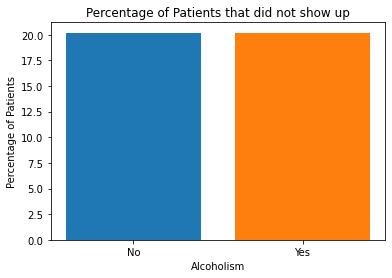

In [31]:
factors = ['Hipertension','Diabetes','Alcoholism']
for factor in factors:
    plot_percentage(factor_percent(factor),factor)

Patients without Diabetes and Hypertension did not show up as much as patients with Diabetes and Hypertension. There's almost no difference between the percentage of patients that didn't show up that are alcoholics and those that are not.

<a id='conclusions'></a>
## Conclusions



### Results:
Based on the analysis above:

1) Gender and alcoholism does not determine whether a patient will show up or not


2) Patients without diabetes and hypertension are less likely to show up for appointments.


3) Some patients who had scholarships or received SMS still didn't show up probably due to other factors.


4) Compared to other age categories, Youth and Children are less likely toshow up for appointments.


5) Patients with handicap levels 3 and 4 are less likely to show up for appointments. This may be because they cannot come on their own.

### Limitations

1) The dataset contains mostly categorical features so I could not obtain the correlation between the features.

## References : 
-Pandas docs: https://pandas.pydata.org/docs/reference/frame.html 

-Matplotlib doc: https://matplotlib.org/stable/plot_types/index.html